In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import gym
from main.alpaca import *
from main.dataset import *
from main.dataViz import *
import yaml

In [3]:
cfg_filename = 'configs/multistep-config.yml'
with open(cfg_filename,'r') as ymlfile:
    config = yaml.load(ymlfile)

In [13]:
noise1 = 0.1
noise2 = 0.3
noise3 = 0.5
dataset1 = MultistepDataset(config, noise_var=noise1, rng=np.random.RandomState(1234))
dataset2 = MultistepDataset(config, noise_var=noise2, rng=np.random.RandomState(1234))
dataset3 = MultistepDataset(config, noise_var=noise3, rng=np.random.RandomState(1234))

## Default agent

In [14]:
g1 = tf.Graph()
sess1 = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True), graph=g1)
agent1 = ALPaCA(config,sess1,g1)
agent1.sigma_eps = noise1
agent1.construct_model()
agent1.train(dataset1,5000)

/home/apoorva/.envs/adapt/lib/python3.5/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


loss: 3.085519
loss: 0.2617318
loss: 0.5335155
loss: 0.40184766
loss: 0.5246447
loss: 0.24722995
loss: 0.16920963
loss: -0.026356168
loss: -0.020356243
loss: 0.053942796
loss: -0.11663618
loss: -0.20603484
loss: -0.09087608
loss: -0.25514346
loss: -0.021573354
loss: -0.0862506
loss: -0.23927978
loss: -0.35883155
loss: -0.31834754
loss: -0.37416974
loss: -0.2709544
loss: -0.24865496
loss: -0.42655239
loss: -0.4264248
loss: -0.39755616
loss: -0.49097255
loss: -0.3974706
loss: -0.61449087
loss: -0.40474805
loss: -0.4029838
loss: -0.42477658
loss: -0.4666051
loss: -0.4450937
loss: -0.32582822
loss: -0.49049205
loss: -0.34926558
loss: -0.32321924
loss: -0.5426521
loss: -0.46417692
loss: -0.49676725
loss: -0.45359704
loss: -0.3572366
loss: -0.513968
loss: -0.43892157
loss: -0.49535197
loss: -0.33448267
loss: -0.42209607
loss: -0.50461215
loss: -0.46277002
loss: -0.45810163
loss: -0.5141567
loss: -0.45096
loss: -0.5044304
loss: -0.51813036
loss: -0.36282778
loss: -0.46034822
loss: -0.46269503

In [15]:
g2 = tf.Graph()
sess2 = tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g2)
agent2 = ALPaCA(config,sess2,g2)
agent2.sigma_eps = noise2
agent2.construct_model()
agent2.train(dataset2,5000)

loss: 1.3316458
loss: 0.66400546
loss: 0.7719472
loss: 0.6141707
loss: 0.55855376
loss: 0.5366085
loss: 0.62318873
loss: 0.45774978
loss: 0.4797994
loss: 0.5264297
loss: 0.4962346
loss: 0.45613313
loss: 0.45092288
loss: 0.5043587
loss: 0.5325354
loss: 0.55697495
loss: 0.43487695
loss: 0.50135
loss: 0.35713613
loss: 0.48876908
loss: 0.488365
loss: 0.36820218
loss: 0.4031654
loss: 0.42904425
loss: 0.46275273
loss: 0.37773538
loss: 0.46232572
loss: 0.27598122
loss: 0.42335308
loss: 0.3541549
loss: 0.4034043
loss: 0.41548488
loss: 0.43028173
loss: 0.36449346
loss: 0.2812601
loss: 0.44979963
loss: 0.4251922
loss: 0.28706312
loss: 0.29241112
loss: 0.2884061
loss: 0.35798845
loss: 0.3552713
loss: 0.291555
loss: 0.34915438
loss: 0.24196327
loss: 0.32614768
loss: 0.3215241
loss: 0.2485619
loss: 0.26620063
loss: 0.3152971
loss: 0.404989
loss: 0.2545669
loss: 0.32525805
loss: 0.28826022
loss: 0.332149
loss: 0.2620606
loss: 0.3171308
loss: 0.3035803
loss: 0.3353293
loss: 0.26178175


In [16]:
g3 = tf.Graph()
sess3 = tf.Session(config=tf.ConfigProto(log_device_placement=True), graph=g3)
agent3 = ALPaCA(config,sess3,g3)
agent3.sigma_eps = noise3
agent3.construct_model()
agent3.train(dataset3,5000)

loss: 1.3119535
loss: 1.1431235
loss: 0.9348562
loss: 0.7824756
loss: 0.8780676
loss: 0.9058966
loss: 0.7931813
loss: 0.76959234
loss: 0.78091156
loss: 0.8217508
loss: 0.8140615
loss: 0.78512794
loss: 0.7709122
loss: 0.8258887
loss: 0.8501526
loss: 0.84840614
loss: 0.7472816
loss: 0.80753183
loss: 0.79012686
loss: 0.760219
loss: 0.8277122
loss: 0.69768095
loss: 0.67005455
loss: 0.7878308
loss: 0.7733761
loss: 0.73429716
loss: 0.7548831
loss: 0.63915545
loss: 0.75119895
loss: 0.6960919
loss: 0.6996427
loss: 0.75277615
loss: 0.6978053
loss: 0.7131542
loss: 0.6630943
loss: 0.82835734
loss: 0.77411693
loss: 0.6055415
loss: 0.68645203
loss: 0.66994244
loss: 0.67359847
loss: 0.7239546
loss: 0.6094622
loss: 0.73027015
loss: 0.64562577
loss: 0.72625256
loss: 0.7179875
loss: 0.65316325
loss: 0.7180798
loss: 0.6291765
loss: 0.73645484
loss: 0.67011046
loss: 0.6720253
loss: 0.66229814
loss: 0.7343694
loss: 0.657889
loss: 0.68736106
loss: 0.7460248
loss: 0.69001865
loss: 0.64702666
loss: 0.6534768

# Visualize all agents

In [17]:
N_test = 50
test_horz = 30
dataset1 = MultistepDataset(config, noise_var=noise1, rng=np.random.RandomState(4321))
dataset2 = MultistepDataset(config, noise_var=noise2, rng=np.random.RandomState(4321))
dataset3 = MultistepDataset(config, noise_var=noise3, rng=np.random.RandomState(4321))
X_test1, Y_test1, step_mat_test = dataset1.sample(N_test, test_horz, return_lists=True)
X_test2, Y_test2 = dataset2.sample(N_test, test_horz, return_lists=False)
X_test3, Y_test3 = dataset3.sample(N_test, test_horz, return_lists=False)

/home/apoorva/.envs/adapt/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/apoorva/.envs/adapt/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


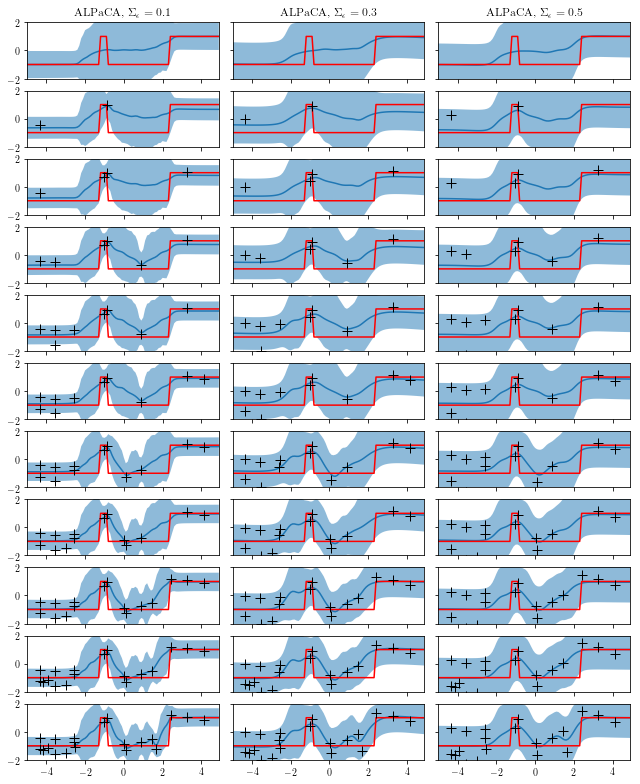

In [18]:
ind = 4
sample_size_list = [0,2,4,6,8,10,12,14,16,18,20]
plt.figure(figsize=(9,len(sample_size_list)*1))
for i,num_pts in enumerate(sample_size_list):
    X_update1 = X_test1[ind:(ind+1),:num_pts,:]
    Y_update1 = Y_test1[ind:(ind+1),:num_pts,:]
    
    X_update2 = X_test2[ind:(ind+1),:num_pts,:]
    Y_update2 = Y_test2[ind:(ind+1),:num_pts,:]
    
    X_update3 = X_test3[ind:(ind+1),:num_pts,:]
    Y_update3 = Y_test3[ind:(ind+1),:num_pts,:]
    
    title=None
    legend=False
    if i == 0:
        legend=True
        title=True

    ax1 = plt.subplot(len(sample_size_list),3,3*i+1)
    gen_multistep_fig(agent1, X_update1, Y_update1, step_mat_test[ind,:], label=None)
    if i == 0:
        plt.title(r'ALPaCA, ' + r'$\Sigma_\epsilon = 0.1$')
    if i < len(sample_size_list) - 1:
        plt.setp(ax1.get_xticklabels(), visible=False)
        
    ax2 = plt.subplot(len(sample_size_list),3,3*i+2, sharey=ax1)
    gen_multistep_fig(agent2, X_update2, Y_update2, step_mat_test[ind,:], label=None)
    plt.setp(ax2.get_yticklabels(), visible=False)
    if i == 0:
        plt.title(r'ALPaCA, ' + r'$\Sigma_\epsilon = 0.3$')
    if i < len(sample_size_list) - 1:
        plt.setp(ax2.get_xticklabels(), visible=False)
    
    
    ax3 = plt.subplot(len(sample_size_list),3,3*i+3, sharey=ax1)
    gen_multistep_fig(agent3, X_update3, Y_update3, step_mat_test[ind,:], label=None)
    plt.setp(ax3.get_yticklabels(), visible=False)
    if i == 0:
        plt.title(r'ALPaCA, ' + r'$\Sigma_\epsilon = 0.5$')
    if i < len(sample_size_list) - 1:
        plt.setp(ax3.get_xticklabels(), visible=False)

plt.tight_layout(w_pad=0.0,h_pad=0.2)
plt.savefig('figures/multistep_varying_noise.pdf')
plt.show()

In [ ]:
K,L = sess1.run([agent.K, agent.L])
x_range = np.reshape( np.linspace(-5,5,100), (1,100,1) )
phi = sess1.run( agent.phi, {agent.x: x_range} ) #agent.encode(sess,x_range)
plot_sample_fns(x_range,phi,K,L,sess1.run(agent.SigEps),10)

In [ ]:
x_range = np.reshape( np.linspace(-5,5,100), (1,100,1) )
gen_sin_bases_fig(agent, sess1, x_range, 32)